In [1]:
import matplotlib.pyplot as plt

In [2]:
# 370 MB
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import sys
from pathlib import Path
module_path = Path('.').resolve().parent
if str(module_path) not in sys.path:
    sys.path.append(str(module_path))

In [4]:
# 682 MB
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
session = tf.Session(config=config)
tf.keras.backend.set_session(session)

In [5]:
# 760 MB
from src.datagens import WSIDatagen, DataSource
from src.training.experiments import SimpleExperiment, SummaryWriter
from src.training.utils import ExperimentLevel
from src.training.models import NASNetModel, ContextNASNetModel
from src.training.metrics import F1
from src.config import SLIDE_DIR

Using TensorFlow backend.


In [8]:
import json
with (Path('.').resolve().parent / 'configs' / 'wsi.json').open('r') as json_in:
    params = json.load(json_in)
params['data']['level'] = 2
tmp = params['data']
params['data'] = {}
params['data']['meta'] = tmp
params['data']['dataset'] = '/home/matejg/Project/crc_ml/data/processed/Prostata/level2/r96px/c32px/t96px/all/datasets/1575200574.h5'

In [9]:
params

{'batch_size': 16,
 'callbacks': {'early_stopping': {'mode': 'max',
   'monitor': 'val_f1',
   'patience': 5,
   'restore_best_weights': True},
  'reduce_lr_on_plateau': {'factor': 0.5,
   'min_lr': 1e-07,
   'mode': 'max',
   'monitor': 'val_f1',
   'patience': 2}},
 'data': {'dataset': '/home/matejg/Project/crc_ml/data/processed/Prostata/level2/r96px/c32px/t96px/all/datasets/1575200574.h5',
  'meta': {'context_size': 1, 'level': 2, 'tile_size': 96}},
 'model': {'checkpoint': None,
  'dropout': 0.5,
  'input_shape': [96, 96, 3],
  'intermed': [],
  'l1_reg': None,
  'l2_reg': None,
  'learning_rate': 0.0005,
  'output_size': 1,
  'trainable': True},
 'test': {'augment_type': None,
  'max_queue_size': 5,
  'use_multiprocessing': False,
  'workers': 2},
 'train': {'epochs': 2,
  'max_queue_size': 5,
  'steps_per_epoch': 10000,
  'train_augment_type': None,
  'use_multiprocessing': False,
  'valid_augment_type': None,
  'validation_steps': 2000,
  'workers': 2}}

In [10]:
# CREATE DATASOURCE
ds = DataSource()
ds.add_dataset(params['data']['dataset'], 'train')
train_ds, valid_ds = ds.split(0.03)

test_ds = DataSource()
test_ds.add_dataset(params['data']['dataset'], 'test')

In [12]:
# CREATE DATAGEN
datagen = WSIDatagen(**params['data']['meta'], slide_dir=SLIDE_DIR, batch_size=params['batch_size'])

In [13]:
# RETRIEVE GENERATORS (877 MB)
train_gen, valid_gen = datagen.get_training_generator((96,96), 8192, 1024, train_ds, valid_ds, 'train', None)

In [33]:
X,y = train_gen[0]
Xu, yu = train_gen.unaugmented(0)

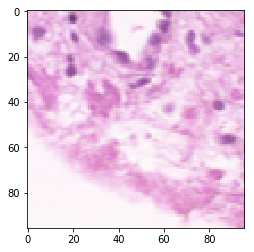

In [31]:
new_im = ((Xu[10] + 1) * 127.5).astype(np.uint8)
plt.imshow(new_im)

In [34]:
# 1273 MB
model = NASNetModel(**params['model'])
model.compile_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
model.model.load_weights('/home/matejg/early.hdf5')

In [35]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(**params['callbacks']['early_stopping'], verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(**params['callbacks']['reduce_lr_on_plateau'], verbose=1)
]

In [36]:
sw = SummaryWriter(params, 'Jupyter test', ExperimentLevel.DEBUG)

In [37]:
script_path = str(Path('.').absolute() / 'new-runscript.ipynb')
experiment = SimpleExperiment(model.model, datagen, sw, script_path, eid_prefix='jupyter-deleteme', seed=1994)

In [40]:
experiment.train(**params['train'], train_ds=train_ds, valid_ds=valid_ds, callbacks=callbacks)

Epoch 1/2
 5351/10000 [===============>..............] - ETA: 36:35 - loss: 0.3792 - binary_accuracy: 0.8340 - precision: 0.8443 - recall: 0.8167 - f1: 0.8303

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2000/2000 [==============================] - 808s 404ms/step - loss: 0.6540 - binary_accuracy: 0.7748 - precision: 0.9494 - recall: 0.5817 - f1: 0.7214

Epoch 00001: val_f1 improved from -inf to 0.72137, saving model to /home/matejg/Project/crc_ml/models/checkpoints/jupyter-deleteme-1034-4eb3-85fd-e94a30f3e099/early.hdf5

Epoch 00001: saving model to /home/matejg/Project/crc_ml/models/checkpoints/jupyter-deleteme-1034-4eb3-85fd-e94a30f3e099/final.hdf5
10000/10000 [==============================] - 8899s 890ms/step - loss: 0.3518 - binary_accuracy: 0.8480 - precision: 0.8591 - recall: 0.8311 - f1: 0.8449 - val_loss: 0.6540 - val_binary_accuracy: 0.7748 - val_precision: 0.9494 - val_recall: 0.5817 - val_f1: 0.7214
Epoch 2/2
2000/2000 [==============================] - 823s 412ms/step - loss: 0.6097 - binary_accuracy: 0.7807 - precision: 0.9013 - recall: 0.6283 - f1: 0.7405

Epoch 00002: val_f1 improved from 0.72137 to 0.74046, saving model to /home/matejg/Project/crc_ml/models/checkpoint